<a href="https://colab.research.google.com/github/Jenoprabakar/DeepLearning-lab-experiments/blob/main/dl_lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3100650419.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline Accuracy: 0.7988826815642458
Augmented + Adaptive LR Accuracy: 0.7988826815642458


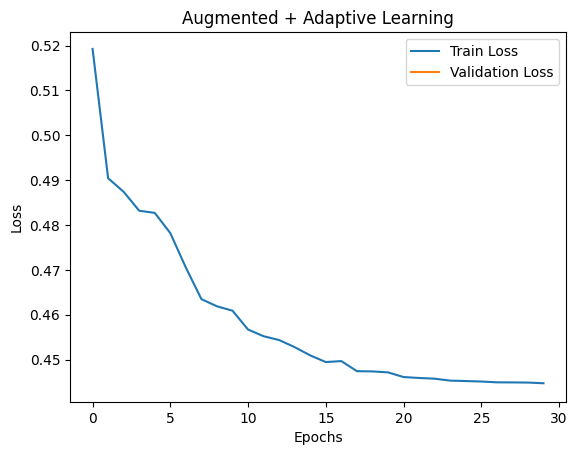

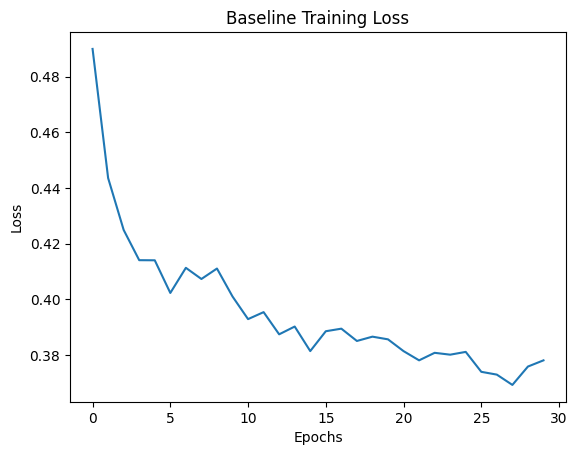

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

data = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

data = data[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare']]
data['Age'].fillna(data['Age'].median(), inplace=True)

le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

X = data.drop('Survived', axis=1).values
y = data['Survived'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def noise_augmentation(X, y, factor=0.05):
    noise = np.random.normal(0, factor, X.shape)
    return np.vstack((X, X + noise)), np.hstack((y, y))

def synthetic_generation(X, y):
    idx = np.random.randint(0, X.shape[0], X.shape[0])
    synthetic = (X + X[idx]) / 2
    return np.vstack((X, synthetic)), np.hstack((y, y))

X_aug, y_aug = noise_augmentation(X_train, y_train)
X_aug, y_aug = synthetic_generation(X_aug, y_aug)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.01)
loss_fn = BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn)

best_loss = np.inf
patience = 3
wait = 0

for epoch in range(30):
    model.fit(X_aug, y_aug, epochs=1, batch_size=32, verbose=0)
    val_pred = model.predict(X_val, verbose=0)
    val_loss = loss_fn(y_val, val_pred).numpy()
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            optimizer.learning_rate.assign(optimizer.learning_rate * 0.5)
            wait = 0

baseline_model = Sequential([
    Dense(32, activation='relu', input_shape=(X.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer=Adam(0.01), loss=loss_fn)
baseline_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

aug_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int)
base_pred = (baseline_model.predict(X_val, verbose=0) > 0.5).astype(int)

print("Baseline Accuracy:", accuracy_score(y_val, base_pred))
print("Augmented + Adaptive LR Accuracy:", accuracy_score(y_val, aug_pred))

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Augmented + Adaptive Learning")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

plt.figure()
plt.plot(bh.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Baseline Training Loss")
plt.show()